In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/Project 3A

/content/drive/MyDrive/Colab Notebooks/Project 3A


In [3]:
def image_crop(img_path,dir,step,size):
  # INPUT:
  # img_path = input image path to be cropped | or hdf file path ("/a/b/c.hdf")
  # dir = directory for saving cropped images
  # step, size: parameters of "sliding_window()"

  # OUTPUT: images cropped from the image in img_path, saved to dir

  if Path(img_path).suffix == ".hdf":
    img_day, img_night = read_modis(img_path)
    if img_day is None or img_night is None:
      print("Cannot handle this MODIS file: ", img_path, ". Please check it again")
    else:
      # For day image
      win_count = 0
      for (x,y,window) in sliding_window(img_day, step, size):
        if window.shape[0] != size[0] or window.shape[1] != size[1]:
          continue
        # img_cropped_name = os.path.split(img_path)[1].split(".")[0] + "_%d"%win_count + ".png"
        img_cropped_name = Path(img_path).stem + ".day.%d"%win_count
        save_path = os.path.join(dir,img_cropped_name)
        # save_path = dir + "/" + img_cropped_name
        img_cropped = window
        # io.imsave(save_path,img_cropped)
        np.save(save_path,img_cropped)
        win_count += 1
      print("Number of cropped day images", win_count)

      # For night image
      win_count = 0
      for (x,y,window) in sliding_window(img_night, step, size):
        if window.shape[0] != size[0] or window.shape[1] != size[1]:
          continue
        # img_cropped_name = os.path.split(img_path)[1].split(".")[0] + "_%d"%win_count + ".png"
        img_cropped_name = Path(img_path).stem + ".night.%d"%win_count
        save_path = os.path.join(dir,img_cropped_name)
        # save_path = dir + "/" + img_cropped_name
        img_cropped = window
        # io.imsave(save_path,img_cropped)
        np.save(save_path,img_cropped)
        win_count += 1
      print("Number of cropped night images", win_count)

  else:
    img = io.imread(img_path)
    if img is None:
      print("This is not an image")
    else:
      win_count = 0
      for (x,y,window) in sliding_window(img, step, size):
        if window.shape[0] != size[0] or window.shape[1] != size[1]:
          continue
        # img_cropped_name = os.path.split(img_path)[1].split(".")[0] + "_%d"%win_count + ".png"
        img_cropped_name = Path(img_path).stem + ".%d"%win_count + ".png"
        save_path = os.path.join(dir,img_cropped_name)
        # save_path = dir + "/" + img_cropped_name
        img_cropped = window
        io.imsave(save_path,img_cropped)
        win_count += 1
      print("Number of cropped images", win_count)

In [4]:
import torch.nn as nn
import torch.nn.functional as F
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=2, padding_mode='replicate')
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=2, padding_mode='replicate')
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2, padding_mode='replicate')
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [5]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import time
import h5py
import torch.optim as optim
import torch.nn as nn
import numpy as np
import math
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

In [6]:
# learning parameters
batch_size = 8 # batch size, reduce if facing OOM error
epochs = 100 # number of epochs to train the SRCNN model for
lr = 0.001 # the learning rate
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
# input image dimensions
img_rows, img_cols = 512, 512
out_rows, out_cols = 512, 512

In [8]:
# Read input
input_train_path = "dataset/low_res/train/"
input_test_path = "dataset/low_res/test/"

output_train_path = "dataset/high_res/train/"
output_test_path = "dataset/high_res/test/"


In [9]:
from glob import glob
train_files = glob(input_train_path + "*npy")
test_files = glob(input_test_path + "*npy")

train_labels = glob(output_train_path + "*npy")
test_labels = glob(output_test_path + "*npy")

In [10]:
import cv2

In [26]:
x_train = np.zeros((len(train_files), 512, 512))
x_val = np.zeros((len(test_files), 512, 512))
y_train = np.zeros((len(train_labels), 512, 512))
y_val = np.zeros((len(test_labels), 512, 512))

i = 0
for fntrl in train_labels:
  print(i)  
  y_train[i] = np.load(fntrl)
  a = cv2.resize(y_train[i], (256,256))
  x_train[i] = cv2.resize(a, (512,512), cv2.INTER_CUBIC)
  i += 1

i = 0
for fntel in test_labels:
  y_val[i] = np.load(fntel)
  a = cv2.resize(y_val[i], (256,256))
  x_val[i] = cv2.resize(a, (512,512), cv2.INTER_CUBIC)
  i += 1

# x_train = np.array(x_train, dtype = np.float32)
# x_val = np.array(x_val, dtype = np.float32)
# y_train = np.array(y_train, dtype = np.float32)
# y_val = np.array(y_val, dtype = np.float32)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [19]:
print('Training samples: ', x_train.shape[0])
print('Validation samples: ', x_val.shape[0])

Training samples:  2394
Validation samples:  968


In [29]:
x_train = x_train.reshape((x_train.shape[0], 1, 512, 512))
x_val = x_val.reshape((x_val.shape[0], 1, 512, 512))
y_train = y_train.reshape((y_train.shape[0], 1, 512, 512))
y_val = y_val.reshape((y_val.shape[0], 1, 512, 512))

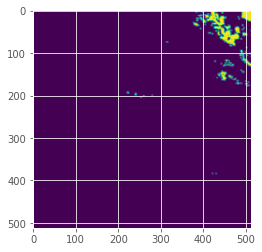

In [27]:
plt.imshow(x_train[0,:,:])


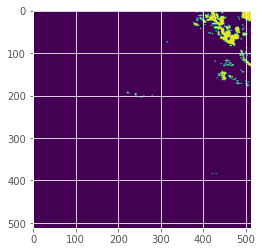

In [28]:
plt.imshow(y_train[0,:,:])

In [30]:
# the dataset module
class SRCNNDataset(Dataset):
    def __init__(self, image_data, labels):
        self.image_data = image_data
        self.labels = labels
    def __len__(self):
        return (len(self.image_data))
    def __getitem__(self, index):
        image = self.image_data[index]
        label = self.labels[index]
        return (
            torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.float)
        )

In [31]:
# train and validation data
train_data = SRCNNDataset(x_train, y_train)
val_data = SRCNNDataset(x_val, y_val)
# train and validation loaders
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [32]:
# initialize the model
print('Computation device: ', device)
model = SRCNN().to(device)
print(model)

Computation device:  cuda
SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
)


In [33]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# loss function 
criterion = nn.MSELoss()

In [38]:
def psnr(label, outputs, max_val=1.):
    """
    Compute Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition
    First we need to convert torch tensors to NumPy operable.
    """
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    img_diff = outputs - label
    rmse = math.sqrt(np.mean((img_diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(np.max(label) / rmse)
        return PSNR

In [39]:
def train(model, dataloader):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0
    for bi, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        image_data = data[0].to(device)
        label = data[1].to(device)
        
        # zero grad the optimizer
        optimizer.zero_grad()
        outputs = model(image_data)
        loss = criterion(outputs, label)
        # backpropagation
        loss.backward()
        # update the parameters
        optimizer.step()
        # add loss of each item (total items in a batch = batch size)
        running_loss += loss.item()
        # calculate batch psnr (once every `batch_size` iterations)
        batch_psnr =  psnr(label, outputs)
        running_psnr += batch_psnr
    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/int(len(train_data)/dataloader.batch_size)
    return final_loss, final_psnr

In [40]:
def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            image_data = data[0].to(device)
            label = data[1].to(device)
            
            outputs = model(image_data)
            loss = criterion(outputs, label)
            # add loss of each item (total items in a batch = batch size) 
            running_loss += loss.item()
            # calculate batch psnr (once every `batch_size` iterations)
            batch_psnr = psnr(label, outputs)
            running_psnr += batch_psnr
        outputs = outputs.cpu()
        # save_image(outputs, f"../outputs/val_sr{epoch}.png")
    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/int(len(val_data)/dataloader.batch_size)
    return final_loss, final_psnr

In [41]:
train_loss, val_loss = [], []
train_psnr, val_psnr = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    train_epoch_loss, train_epoch_psnr = train(model, train_loader)
    val_epoch_loss, val_epoch_psnr = validate(model, val_loader, epoch)
    print(f"Train PSNR: {train_epoch_psnr:.3f}")
    print(f"Val PSNR: {val_epoch_psnr:.3f}")
    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)
end = time.time()
print(f"Finished training in: {((end-start)/60):.3f} minutes")

Epoch 1 of 100


300it [00:59,  5.02it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.25it/s]


Train PSNR: 23.510
Val PSNR: 22.445
Epoch 2 of 100


300it [00:59,  5.02it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.40it/s]


Train PSNR: 24.055
Val PSNR: 22.735
Epoch 3 of 100


300it [00:59,  5.02it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.35it/s]


Train PSNR: 24.281
Val PSNR: 22.895
Epoch 4 of 100


300it [00:59,  5.02it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.32it/s]


Train PSNR: 24.416
Val PSNR: 23.013
Epoch 5 of 100


300it [00:59,  5.02it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.40it/s]


Train PSNR: 24.419
Val PSNR: 23.090
Epoch 6 of 100


300it [00:59,  5.01it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.31it/s]


Train PSNR: 24.589
Val PSNR: 23.154
Epoch 7 of 100


300it [00:59,  5.02it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.25it/s]


Train PSNR: 24.398
Val PSNR: 23.135
Epoch 8 of 100


300it [00:59,  5.02it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.36it/s]


Train PSNR: 24.666
Val PSNR: 23.231
Epoch 9 of 100


300it [00:59,  5.02it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.26it/s]


Train PSNR: 24.728
Val PSNR: 23.275
Epoch 10 of 100


300it [00:59,  5.02it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.39it/s]


Train PSNR: 24.774
Val PSNR: 23.326
Epoch 11 of 100


300it [00:59,  5.04it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.71it/s]


Train PSNR: 24.720
Val PSNR: 23.337
Epoch 12 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.66it/s]


Train PSNR: 24.836
Val PSNR: 23.386
Epoch 13 of 100


300it [00:59,  5.05it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.64it/s]


Train PSNR: 24.869
Val PSNR: 23.415
Epoch 14 of 100


300it [00:59,  5.05it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.69it/s]


Train PSNR: 24.824
Val PSNR: 23.435
Epoch 15 of 100


300it [00:59,  5.05it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.66it/s]


Train PSNR: 24.934
Val PSNR: 23.459
Epoch 16 of 100


300it [00:59,  5.05it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.57it/s]


Train PSNR: 24.958
Val PSNR: 23.478
Epoch 17 of 100


300it [00:59,  5.05it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.55it/s]


Train PSNR: 24.932
Val PSNR: 23.496
Epoch 18 of 100


300it [00:59,  5.05it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.66it/s]


Train PSNR: 25.000
Val PSNR: 23.519
Epoch 19 of 100


300it [00:59,  5.04it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.54it/s]


Train PSNR: 24.939
Val PSNR: 23.540
Epoch 20 of 100


300it [00:59,  5.04it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.54it/s]


Train PSNR: 25.049
Val PSNR: 23.562
Epoch 21 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.58it/s]


Train PSNR: 25.059
Val PSNR: 23.582
Epoch 22 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.78it/s]


Train PSNR: 24.983
Val PSNR: 23.590
Epoch 23 of 100


300it [00:59,  5.07it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.61it/s]


Train PSNR: 25.106
Val PSNR: 23.618
Epoch 24 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.68it/s]


Train PSNR: 25.128
Val PSNR: 23.638
Epoch 25 of 100


300it [00:59,  5.07it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.47it/s]


Train PSNR: 25.103
Val PSNR: 23.658
Epoch 26 of 100


300it [00:59,  5.05it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.85it/s]


Train PSNR: 25.178
Val PSNR: 23.674
Epoch 27 of 100


300it [00:59,  5.05it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.68it/s]


Train PSNR: 25.163
Val PSNR: 23.698
Epoch 28 of 100


300it [00:59,  5.07it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.51it/s]


Train PSNR: 25.093
Val PSNR: 23.692
Epoch 29 of 100


300it [00:59,  5.07it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.80it/s]


Train PSNR: 25.220
Val PSNR: 23.720
Epoch 30 of 100


300it [00:59,  5.07it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.78it/s]


Train PSNR: 25.245
Val PSNR: 23.733
Epoch 31 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.77it/s]


Train PSNR: 25.192
Val PSNR: 23.749
Epoch 32 of 100


300it [00:59,  5.05it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.71it/s]


Train PSNR: 25.283
Val PSNR: 23.762
Epoch 33 of 100


300it [00:59,  5.05it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.59it/s]


Train PSNR: 25.230
Val PSNR: 23.777
Epoch 34 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.74it/s]


Train PSNR: 25.313
Val PSNR: 23.790
Epoch 35 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.72it/s]


Train PSNR: 25.328
Val PSNR: 23.805
Epoch 36 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.66it/s]


Train PSNR: 25.206
Val PSNR: 23.811
Epoch 37 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.66it/s]


Train PSNR: 25.348
Val PSNR: 23.828
Epoch 38 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.70it/s]


Train PSNR: 25.366
Val PSNR: 23.841
Epoch 39 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.57it/s]


Train PSNR: 25.360
Val PSNR: 23.861
Epoch 40 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.91it/s]


Train PSNR: 25.372
Val PSNR: 23.871
Epoch 41 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.73it/s]


Train PSNR: 25.372
Val PSNR: 23.879
Epoch 42 of 100


300it [00:59,  5.07it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.79it/s]


Train PSNR: 25.400
Val PSNR: 23.891
Epoch 43 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.74it/s]


Train PSNR: 25.366
Val PSNR: 23.899
Epoch 44 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.63it/s]


Train PSNR: 25.426
Val PSNR: 23.908
Epoch 45 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.67it/s]


Train PSNR: 25.426
Val PSNR: 23.921
Epoch 46 of 100


300it [00:59,  5.07it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.72it/s]


Train PSNR: 25.440
Val PSNR: 23.922
Epoch 47 of 100


300it [00:59,  5.07it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.68it/s]


Train PSNR: 25.398
Val PSNR: 23.932
Epoch 48 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.81it/s]


Train PSNR: 25.471
Val PSNR: 23.944
Epoch 49 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.73it/s]


Train PSNR: 25.475
Val PSNR: 23.948
Epoch 50 of 100


300it [00:59,  5.07it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.74it/s]


Train PSNR: 25.423
Val PSNR: 23.958
Epoch 51 of 100


300it [00:59,  5.07it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.66it/s]


Train PSNR: 25.502
Val PSNR: 23.962
Epoch 52 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.73it/s]


Train PSNR: 25.488
Val PSNR: 23.972
Epoch 53 of 100


300it [00:59,  5.07it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.65it/s]


Train PSNR: 25.462
Val PSNR: 23.976
Epoch 54 of 100


300it [00:59,  5.07it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.50it/s]


Train PSNR: 25.520
Val PSNR: 23.982
Epoch 55 of 100


300it [00:59,  5.05it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.64it/s]


Train PSNR: 25.476
Val PSNR: 23.994
Epoch 56 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.63it/s]


Train PSNR: 25.534
Val PSNR: 23.999
Epoch 57 of 100


300it [00:59,  5.05it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.75it/s]


Train PSNR: 25.499
Val PSNR: 24.009
Epoch 58 of 100


300it [00:59,  5.05it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.67it/s]


Train PSNR: 25.483
Val PSNR: 24.010
Epoch 59 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.71it/s]


Train PSNR: 25.554
Val PSNR: 24.016
Epoch 60 of 100


300it [00:59,  5.07it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.66it/s]


Train PSNR: 25.523
Val PSNR: 24.016
Epoch 61 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.72it/s]


Train PSNR: 25.545
Val PSNR: 24.029
Epoch 62 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.71it/s]


Train PSNR: 25.569
Val PSNR: 24.030
Epoch 63 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.71it/s]


Train PSNR: 25.546
Val PSNR: 24.042
Epoch 64 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.69it/s]


Train PSNR: 25.580
Val PSNR: 24.041
Epoch 65 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.52it/s]


Train PSNR: 25.530
Val PSNR: 24.048
Epoch 66 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.58it/s]


Train PSNR: 25.593
Val PSNR: 24.052
Epoch 67 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.64it/s]


Train PSNR: 25.562
Val PSNR: 24.053
Epoch 68 of 100


300it [00:59,  5.05it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.67it/s]


Train PSNR: 25.598
Val PSNR: 24.060
Epoch 69 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.46it/s]


Train PSNR: 25.523
Val PSNR: 24.047
Epoch 70 of 100


300it [00:59,  5.05it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.69it/s]


Train PSNR: 25.609
Val PSNR: 24.062
Epoch 71 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.54it/s]


Train PSNR: 25.546
Val PSNR: 24.071
Epoch 72 of 100


300it [00:59,  5.05it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.70it/s]


Train PSNR: 25.623
Val PSNR: 24.070
Epoch 73 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.64it/s]


Train PSNR: 25.597
Val PSNR: 24.081
Epoch 74 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.59it/s]


Train PSNR: 25.623
Val PSNR: 24.081
Epoch 75 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.67it/s]


Train PSNR: 25.560
Val PSNR: 24.085
Epoch 76 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.83it/s]


Train PSNR: 25.642
Val PSNR: 24.084
Epoch 77 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.77it/s]


Train PSNR: 25.569
Val PSNR: 24.091
Epoch 78 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.66it/s]


Train PSNR: 25.637
Val PSNR: 24.096
Epoch 79 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.56it/s]


Train PSNR: 25.619
Val PSNR: 24.096
Epoch 80 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.70it/s]


Train PSNR: 25.643
Val PSNR: 24.102
Epoch 81 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.74it/s]


Train PSNR: 25.636
Val PSNR: 24.104
Epoch 82 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.70it/s]


Train PSNR: 25.643
Val PSNR: 24.106
Epoch 83 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.59it/s]


Train PSNR: 25.615
Val PSNR: 24.111
Epoch 84 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.69it/s]


Train PSNR: 25.633
Val PSNR: 24.107
Epoch 85 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.70it/s]


Train PSNR: 25.644
Val PSNR: 24.114
Epoch 86 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.83it/s]


Train PSNR: 25.665
Val PSNR: 24.117
Epoch 87 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.87it/s]


Train PSNR: 25.566
Val PSNR: 24.103
Epoch 88 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.67it/s]


Train PSNR: 25.666
Val PSNR: 24.117
Epoch 89 of 100


300it [00:59,  5.07it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.68it/s]


Train PSNR: 25.624
Val PSNR: 24.111
Epoch 90 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.67it/s]


Train PSNR: 25.669
Val PSNR: 24.118
Epoch 91 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.60it/s]


Train PSNR: 25.558
Val PSNR: 24.099
Epoch 92 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.78it/s]


Train PSNR: 25.677
Val PSNR: 24.124
Epoch 93 of 100


300it [00:59,  5.07it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.72it/s]


Train PSNR: 25.692
Val PSNR: 24.125
Epoch 94 of 100


300it [00:59,  5.07it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.65it/s]


Train PSNR: 25.597
Val PSNR: 24.098
Epoch 95 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.68it/s]


Train PSNR: 25.587
Val PSNR: 24.113
Epoch 96 of 100


300it [00:59,  5.05it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.57it/s]


Train PSNR: 25.680
Val PSNR: 24.117
Epoch 97 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.59it/s]


Train PSNR: 25.682
Val PSNR: 24.126
Epoch 98 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.57it/s]


Train PSNR: 25.652
Val PSNR: 24.126
Epoch 99 of 100


300it [00:59,  5.06it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.64it/s]


Train PSNR: 25.673
Val PSNR: 24.130
Epoch 100 of 100


300it [00:59,  5.05it/s]                         
100%|██████████| 121/121 [00:08<00:00, 14.67it/s]

Train PSNR: 25.613
Val PSNR: 24.122
Finished training in: 112.719 minutes


In [42]:
torch.save(model.state_dict(), 'model.pth')

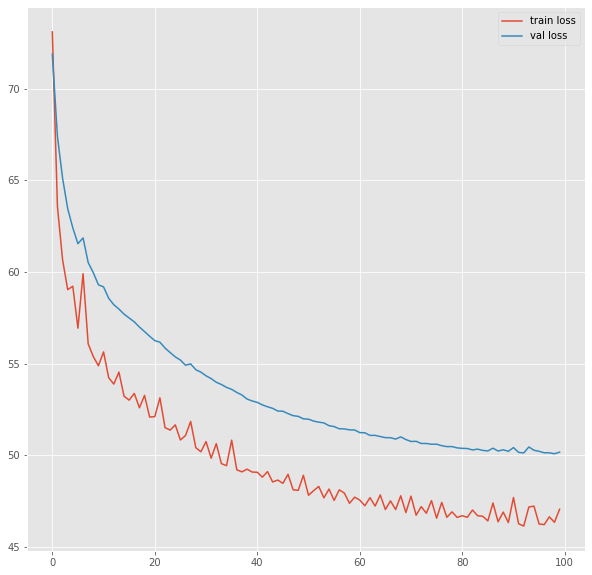

In [43]:
plt.figure(figsize=(10,10))
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(["train loss", "val loss"])

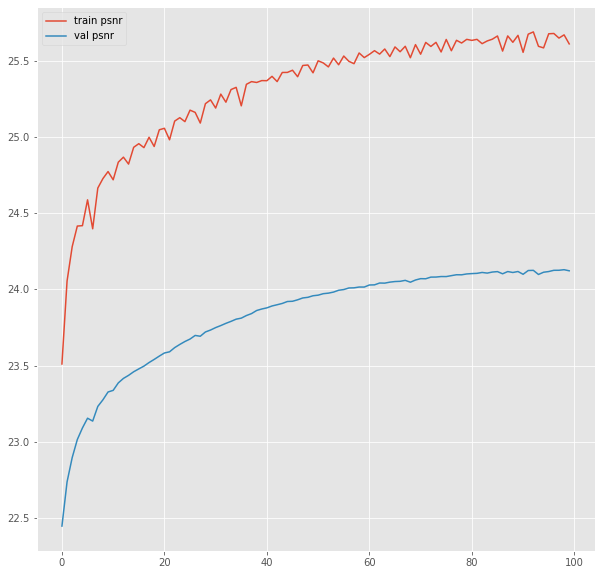

In [87]:
plt.figure(figsize=(10,10))
plt.plot(train_psnr)
plt.plot(val_psnr)
plt.legend(["train psnr", "val psnr"])

In [52]:
def psnr_notorch(label, outputs):
    """
    Compute Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition
    First we need to convert torch tensors to NumPy operable.
    """
    # label = label.cpu().detach().numpy()
    # outputs = outputs.cpu().detach().numpy()
    img_diff = outputs - label
    rmse = math.sqrt(np.mean((img_diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(np.max(label) / rmse)
        return PSNR, rmse

In [61]:
PSNR_bicubic, rmse = psnr_notorch(y_train[1084,0,:,:], x_train[1084,0,:,:])
print(PSNR_bicubic, rmse)

18.595653705137345 33.24978579401727


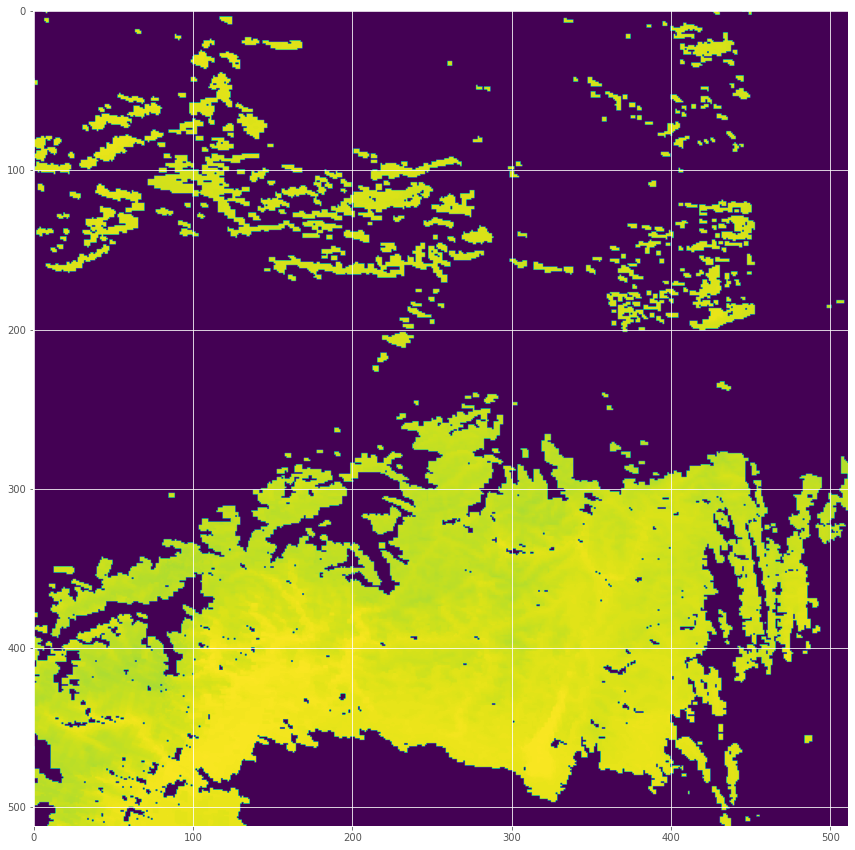

In [64]:
plt.figure(figsize=(15,15))
plt.imshow(y_train[1084,0,:,:])

In [71]:
input = torch.tensor(np.reshape(x_train[1084,:,:,:], (1,1,512,512)), dtype=torch.float)
input = input.to(device)

In [74]:
output = model(input).cpu().detach().numpy()

In [76]:
PSNR_bicubic, rmse = psnr_notorch(y_train[1084,0,:,:], output[0,0,:,:])
print(PSNR_bicubic, rmse)

22.826388046785745 20.42923643467386


In [81]:
np.max(y_train[1084,0,:,:]), np.max(output)

(282.86, 343.3493)

Text(0.5, 1.0, 'Bicubic')

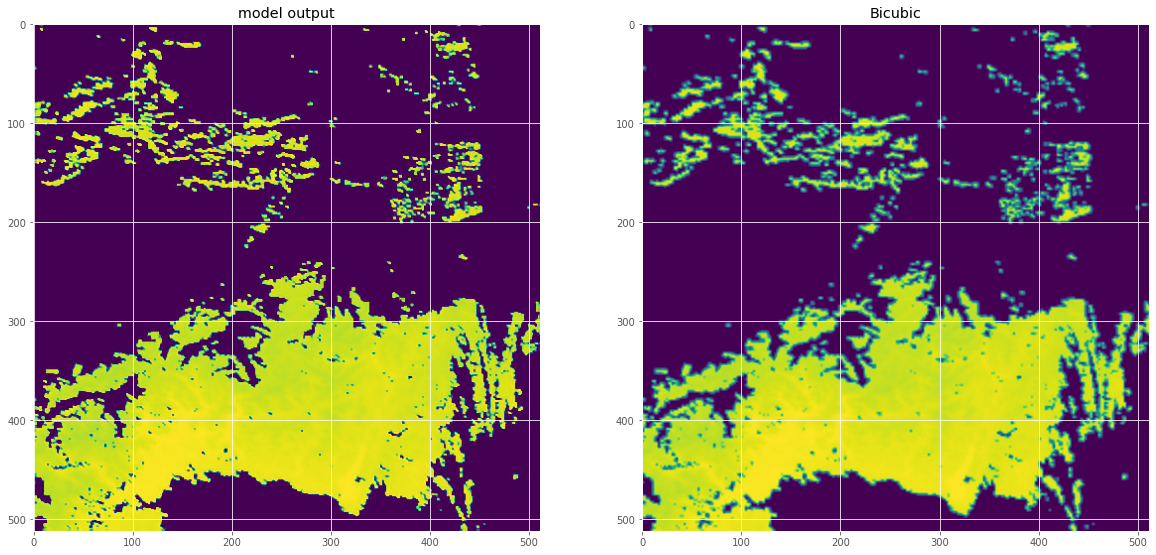

In [85]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(output[0,0,:,:], vmin = 0, vmax = np.max(x_train[1084,0,:,:]))
plt.title("model output")
plt.subplot(1,2,2)
plt.imshow(x_train[1084,0,:,:])
plt.title("Bicubic")

In [86]:
np.max(x_train[1084,0,:,:])

281.27250000000004